In [1]:
import pandas as pd
import numpy as np
import os
import  matplotlib.pyplot as plt

In [110]:
data = pd.read_csv("data/AAPL.csv").set_index("Date")
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-02-04,18.066071,18.195000,17.955713,18.171070,15.930423,376681200
2014-02-05,18.091429,18.402857,18.080357,18.306786,16.049400,328344800
2014-02-06,18.216429,18.339287,18.136070,18.303928,16.142952,257765200
2014-02-07,18.620714,18.676071,18.477858,18.559999,16.368792,370280400
2014-02-10,18.523571,18.999643,18.500000,18.892500,16.662041,345559200
...,...,...,...,...,...,...
2024-01-29,192.009995,192.199997,189.580002,191.729996,191.729996,47145600
2024-01-30,190.940002,191.800003,187.470001,188.039993,188.039993,55859400
2024-01-31,187.039993,187.100006,184.350006,184.399994,184.399994,55467800


In [111]:
data['Log_Return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
data = data.dropna()

In [112]:
# Function to calculate realized volatility
def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2) / (5 - 1)) 

data['Realized_Volatility']= data['Log_Return'].rolling(window=5).apply(lambda x: realized_volatility(x))

/tmp/ipykernel_12804/1252634718.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Realized_Volatility']= data['Log_Return'].rolling(window=5).apply(lambda x: realized_volatility(x))


In [113]:
data

,Open,High,Low,Close,Adj Close,Volume,Log_Return,Realized_Volatility
Date,,,,,,,,
2014-02-05,18.091429,18.402857,18.080357,18.306786,16.049400,328344800,0.007441,NaN
2014-02-06,18.216429,18.339287,18.136070,18.303928,16.142952,257765200,0.005812,NaN
2014-02-07,18.620714,18.676071,18.477858,18.559999,16.368792,370280400,0.013893,NaN
2014-02-10,18.523571,18.999643,18.500000,18.892500,16.662041,345559200,0.017757,NaN
2014-02-11,18.950357,19.205357,18.910713,19.141430,16.881578,282256800,0.013090,0.013864
...,...,...,...,...,...,...,...,...
2024-01-29,192.009995,192.199997,189.580002,191.729996,191.729996,47145600,-0.003592,0.006203
2024-01-30,190.940002,191.800003,187.470001,188.039993,188.039993,55859400,-0.019433,0.011041
2024-01-31,187.039993,187.100006,184.350006,184.399994,184.399994,55467800,-0.019547,0.014642


In [114]:

from sklearn.metrics import mean_squared_error

forecast_horizon = 5

# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_copy = data.copy()

# Applying the naive random walk model
df_copy['Forecasted_Volatility_Naive'] = df_copy['Realized_Volatility'].shift(1)
df_copy = df_copy.dropna()


In [116]:
rmspe_values = []
rmse_values = []

for i in range(1, forecast_horizon + 1):
    rmspe = np.sqrt(np.mean(((df_copy['Realized_Volatility'].shift(-i).dropna() - df_copy['Forecasted_Volatility_Naive'].shift(-i).dropna()) / df_copy['Realized_Volatility'].shift(-i).dropna()) ** 2))
    rmse = np.sqrt(mean_squared_error(df_copy['Realized_Volatility'].shift(-i).dropna(), df_copy['Forecasted_Volatility_Naive'].shift(-i).dropna()))
    
    rmspe_values.append(rmspe)
    rmse_values.append(rmse)

# Display the forecasting performance
forecast_performance_df = pd.DataFrame({
    'Forecast Horizon': [f'D+{i}' for i in range(1, forecast_horizon + 1)],
    'RMSPE': rmspe_values,
    'RMSE': rmse_values
})

print(forecast_performance_df)

  Forecast Horizon     RMSPE      RMSE
0              D+1  0.308770  0.004506
1              D+2  0.308822  0.004507
2              D+3  0.308874  0.004507
3              D+4  0.308876  0.004508
4              D+5  0.308934  0.004509


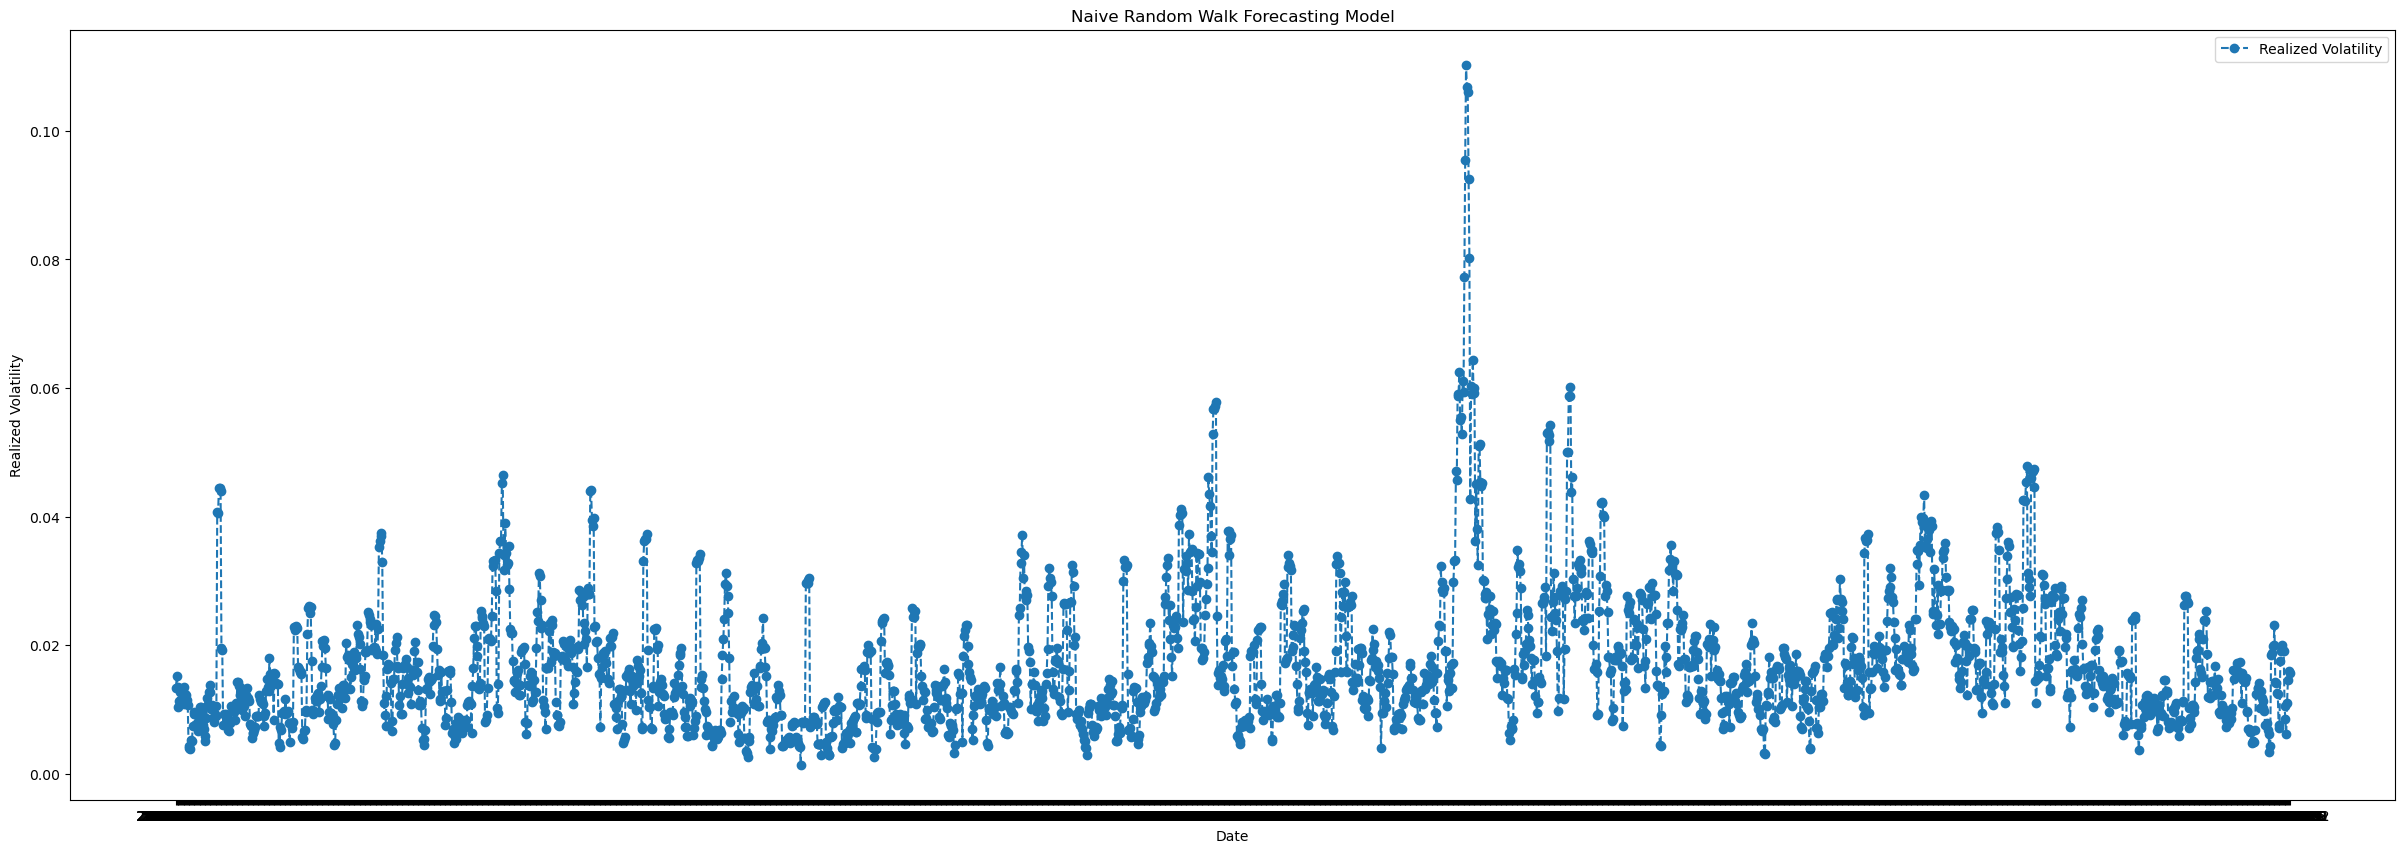

In [119]:
# Plotting the results
plt.figure(figsize=(30, 10))
plt.plot(df_copy.index, df_copy['Realized_Volatility'], label='Realized Volatility', linestyle='--', marker='o')

plt.title('Naive Random Walk Forecasting Model')
plt.xlabel('Date')
plt.ylabel('Realized Volatility')
plt.legend()
plt.show()
